In [13]:
import numpy as np
import pandas as pd
from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from CrossValidation import CVScore
%matplotlib inline

In [2]:
df=pd.read_json(open("../input/train.json"))
print(df.shape)

(49352, 15)


In [3]:
df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [4]:
df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)
df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
df["created"] = pd.to_datetime(df["created"])
df["created_year"] = df["created"].dt.year
df["created_month"] = df["created"].dt.month
df["created_day"] = df["created"].dt.day

In [5]:
num_feats = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
             "num_photos", "num_features", "num_description_words",
             "created_year", "created_month", "created_day"]
X = df[num_feats]
y = df["interest_level"]
X.head()

,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_description_words,created_year,created_month,created_day
10,1.5,3,40.7145,-73.9425,3000,5,0,95,2016,6,24
10000,1.0,2,40.7947,-73.9667,5465,11,5,9,2016,6,12
100004,1.0,1,40.7388,-74.0018,2850,8,4,94,2016,4,17
100007,1.0,1,40.7539,-73.9677,3275,3,2,80,2016,4,18
100013,1.0,4,40.8241,-73.9493,3350,3,1,68,2016,4,28


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=17)

In [7]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
y_val_pred = clf.predict_proba(X_val)
log_loss(y_val, y_val_pred)

0.62765528479258492

In [9]:
CVScore(model=clf, my_score=log_loss, X_train=X, y_train=y, n_splits=5)

0.62686566378925412

In [12]:
imp=pd.DataFrame(index=num_feats)
imp['train']=pd.Series(clf.feature_importances_,index=num_feats)
imp.fillna(0)

,train
bathrooms,0.013839
bedrooms,0.045951
latitude,0.139286
longitude,0.138579
price,0.187974
num_photos,0.089651
num_features,0.085608
num_description_words,0.139264
created_year,0.000000
created_month,0.041132


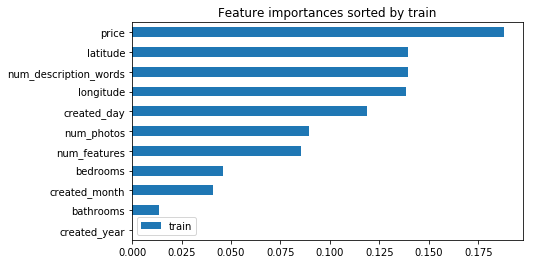

In [15]:
ax=imp.sort_values('train').plot.barh(title='Feature importances sorted by train', figsize=(7,4))

In [ ]:
labels2idx = {label: i for i, label in enumerate(clf.classes_)}
labels2idx

In [ ]:
sub = pd.DataFrame()
sub["listing_id"] = df["listing_id"]
for label in ["high", "medium", "low"]:
    sub[label] = y[:, labels2idx[label]]
sub.to_csv("submission_rf.csv", index=False)